<a href="https://colab.research.google.com/github/Alephant6/nlp-kaggle/blob/main/d2l/14_3_%E7%94%A8%E4%BA%8E%E9%A2%84%E8%AE%AD%E7%BB%83%E8%AF%8D%E5%B5%8C%E5%85%A5%E7%9A%84%E6%95%B0%E6%8D%AE%E9%9B%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l
!pip install matplotlib==3.0.0

In [7]:
import math
import os
import random
import torch
from d2l import torch as d2l

## 14.3.1 正在读取数据集

In [15]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
  data_dir = d2l.download_extract('ptb')
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# senentces数：{len(sentences)}'

'# senentces数：42069'

In [16]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## 14.3.2 下采样

In [18]:
def subsample(sentences, vocab):
  sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
  counter = d2l.count_corpus(sentences)
  num_tokens = sum(counter.values())

  def keep(token):
    return(random.uniform(0, 1)) < math.sqrt(1e-4 / counter[token] * num_tokens)
  return ([[token for token in line if keep(token)] for line in sentences], counter)
subsampled, counter = subsample(sentences, vocab)

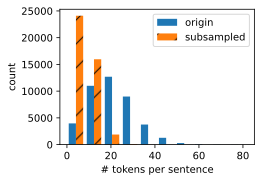

In [19]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
     'count', sentences, subsampled);

In [20]:
def compare_counts(token):
  return (f'"{token}"的数量：'
    f'之前={sum([l.count(token) for l in sentences])}, '
    f'之后={sum([l.count(token) for l in subsampled])}')
compare_counts('the')

'"the"的数量：之前=50770, 之后=2077'

In [21]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [22]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 274], [5277, 3054, 1580]]

In [25]:
def get_centers_and_contexts(corpus, max_window_size):
  centers, contexts = [], []
  for line in corpus:
    if len(line) < 2:
      continue
    centers += line
    for i in range(len(line)):
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, i - window_size), min(len(line), i+1+window_size)))

      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts

In [26]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
  print('中心词', center, '的上下词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下词是 [1, 2]
中心词 1 的上下词是 [0, 2, 3]
中心词 2 的上下词是 [1, 3]
中心词 3 的上下词是 [1, 2, 4, 5]
中心词 4 的上下词是 [2, 3, 5, 6]
中心词 5 的上下词是 [4, 6]
中心词 6 的上下词是 [5]
中心词 7 的上下词是 [8]
中心词 8 的上下词是 [7, 9]
中心词 9 的上下词是 [8]


In [27]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中⼼词-上下⽂词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中⼼词-上下⽂词对”的数量: 1503959'

## 14.3.4 负采样

In [31]:
class RandomGenerator:
  def __init__(self, sampling_weights):
    self.population = list(range(1, len(sampling_weights) + 1))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0
  
  def draw(self):
    if self.i == len(self.candidates):
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000)
      self.i = 0
    self.i += 1
    return self.candidates[self.i - 1]

In [32]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 3, 1, 1, 3, 3, 2, 2, 2]

In [33]:
def get_negatives(all_contexts, vocab, counter, K):
  sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
  all_negatives, generator = [], RandomGenerator(sampling_weights)
  for contexts in all_contexts:
    negatives = []
    while len(negatives) < len(contexts) * K:
      neg = generator.draw()
      if neg not in contexts:
        negatives.append(neg)
    all_negatives.append(negatives)
  return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 14.3.5 小批量加载训练实例

In [34]:
def batchify(data):
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, mask, labels = [], [], [], []
  for center, context, negative in data:
    cur_len = len(context) + len(negative)
    centers += [center]
    contexts_negatives += [context + negative + [0] *(max_len - cur_len)]
    mask += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
  return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
      contexts_negatives), torch.tensor(mask),torch.tensor(labels))

In [36]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
  print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [37]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
  """下载PTB数据集，然后将其加载到内存中"""
  num_workers = d2l.get_dataloader_workers()
  sentences = read_ptb()
  vocab = d2l.Vocab(sentences, min_freq=10)
  subsampled, counter = subsample(sentences, vocab)
  corpus = [vocab[line] for line in subsampled]
  all_centers, all_contexts = get_centers_and_contexts(
      corpus, max_window_size)
  all_negatives = get_negatives(
      all_contexts, vocab, counter, num_noise_words)
  class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
      assert len(centers) == len(contexts) == len(negatives)
      self.centers = centers
      self.contexts = contexts
      self.negatives = negatives
    def __getitem__(self, index):
      return (self.centers[index], self.contexts[index],
              self.negatives[index])
    def __len__(self):
      return len(self.centers)
  dataset = PTBDataset(all_centers, all_contexts, all_negatives)
  data_iter = torch.utils.data.DataLoader(
      dataset, batch_size, shuffle=True,
      collate_fn=batchify, num_workers=num_workers)
  return data_iter, vocab

In [38]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
  for name, data in zip(names, batch):
    print(name,'shape:',data.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
